# Titanic Classification

In [175]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

## Data Preprocessing

first , we will import the data 

In [121]:
df=pd.read_csv('titanic (1).csv')
df_test=pd.read_csv('test (1).csv')
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,1
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,1
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,0
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,0
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,0


In [122]:
df_test.head()

,pclass,name,sex,age,sibSp,parch,ticket,fare,cabin,embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


now we will first start working with null values

In [123]:
df.isnull().sum()

pclass         0
name           0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
survived       0
dtype: int64

In [124]:
df_test.isnull().sum()

pclass       0
name         0
sex          0
age          1
sibSp        0
parch        0
ticket       0
fare         0
cabin       17
embarked     0
dtype: int64

Since cabin has alot of missing values and won't be valuable for our analysis , therefore dropping the cabin row seems as a good choice

In [125]:
df.drop(columns=['cabin'], inplace=True)
df_test.drop(columns=['cabin'], inplace=True)

In [126]:
df.isnull().sum()
df_test.isnull().sum()

pclass      0
name        0
sex         0
age         1
sibSp       0
parch       0
ticket      0
fare        0
embarked    0
dtype: int64

Now we will deal with the embarked missing values 

In [127]:
df[df['embarked'].isnull()]

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,survived
168,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN,1
284,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN,1


Since both share the same ticket number, they must have been travelling together 

In [128]:
df['embarked'].fillna('C',inplace=True)

In [129]:
df['embarked'].isnull().sum()

0

Before dealing with the missing values of ages,we will map the title feature becuase it will be useful in prediciting the age 

In [130]:
df['title'] = df.name.str.extract('([A-Za-z]+)\.')
df_test['title'] = df.name.str.extract('([A-Za-z]+)\.')

In [131]:
df['title'].value_counts

<bound method IndexOpsMixin.value_counts of 0         Miss
1       Master
2         Miss
3           Mr
4          Mrs
         ...  
1304      Miss
1305      Miss
1306        Mr
1307        Mr
1308        Mr
Name: title, Length: 1309, dtype: object>

In [132]:
title_mapping = {'Col':'Army', 'Major':'Army', 'Capt':'Army',
 'Rev':'Noble', 'Countess':'Noble', 'Sir':'Noble',
 'Lady':'Noble', 'Don':'Noble', 'Jonkheer':'Noble',
 'Ms':'Miss', 'Mme':'Mrs', 'Mlle':'Miss', 'Miss':'Miss',
 'Mr':'Mr', 'Mrs':'Mrs', 'Dr':'Dr', 'Master':'Master', 'Dona':'Royalty'}

In [133]:
df['title']=df.title.map(title_mapping)
df_test['title']=df_test.title.map(title_mapping)
df['title'].isnull().sum()

0

In [134]:
df_test['title'].isnull().sum()

0

Now we can start predicting the age 

In [135]:
df.groupby(['pclass','title','sex'])['age'].agg('mean','count')
df_test.groupby(['pclass'])['age'].agg('mean','count')

pclass
1    38.666667
2    42.000000
3    26.150000
Name: age, dtype: float64

After grouping them and seeing the mean age we will fill using the mean value

In [136]:
df['age'].fillna(df.groupby(['pclass', 'title','sex'])['age'].transform('mean'),inplace=True)
df_test['age'].fillna(df.groupby(['pclass', 'title','sex'])['age'].transform('mean'),inplace=True)

In [137]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    19 non-null     int64  
 1   name      19 non-null     object 
 2   sex       19 non-null     object 
 3   age       19 non-null     float64
 4   sibSp     19 non-null     int64  
 5   parch     19 non-null     int64  
 6   ticket    19 non-null     object 
 7   fare      19 non-null     float64
 8   embarked  19 non-null     object 
 9   title     19 non-null     object 
dtypes: float64(2), int64(3), object(5)
memory usage: 1.6+ KB


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   name      1309 non-null   object 
 2   sex       1309 non-null   object 
 3   age       1309 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   ticket    1309 non-null   object 
 7   fare      1308 non-null   float64
 8   embarked  1309 non-null   object 
 9   survived  1309 non-null   int64  
 10  title     1309 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


Now we will deal with the fare missing value

In [139]:
df[df['fare'].isnull()]

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,survived,title
1225,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,0,Mr


One way of filling the missing value could be with calculating the mean fare and just filling the missing value

In [140]:
mean_fare=df['fare'].mean()
mean_fare

33.29547928134557

In [141]:
df['fare'].fillna(mean_fare,inplace=True)

In [142]:
df['fare'].isnull().sum()

0

Now we will encode the categorical features

In [143]:
df.drop(['ticket', 'name'], axis=1, inplace=True)
df_test.drop(['ticket', 'name'], axis=1, inplace=True)

In [173]:
df['family']=df['sibsp']+ df['parch']
df_test.rename(columns={'sibSp': 'sibsp'}, inplace=True)
df_test['family']=df_test['sibsp']+ df_test['parch']

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   sex       1309 non-null   object 
 2   age       1309 non-null   float64
 3   sibsp     1309 non-null   int64  
 4   parch     1309 non-null   int64  
 5   fare      1309 non-null   float64
 6   embarked  1309 non-null   object 
 7   survived  1309 non-null   int64  
 8   title     1309 non-null   object 
 9   family    1309 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 102.4+ KB


## Exploratory Data Analysis

We will start by looking at the survival rate 

In [146]:
df.survived.value_counts()

survived
0    809
1    500
Name: count, dtype: int64

We can first plot a boxplot of the features and the data 

<Axes: >

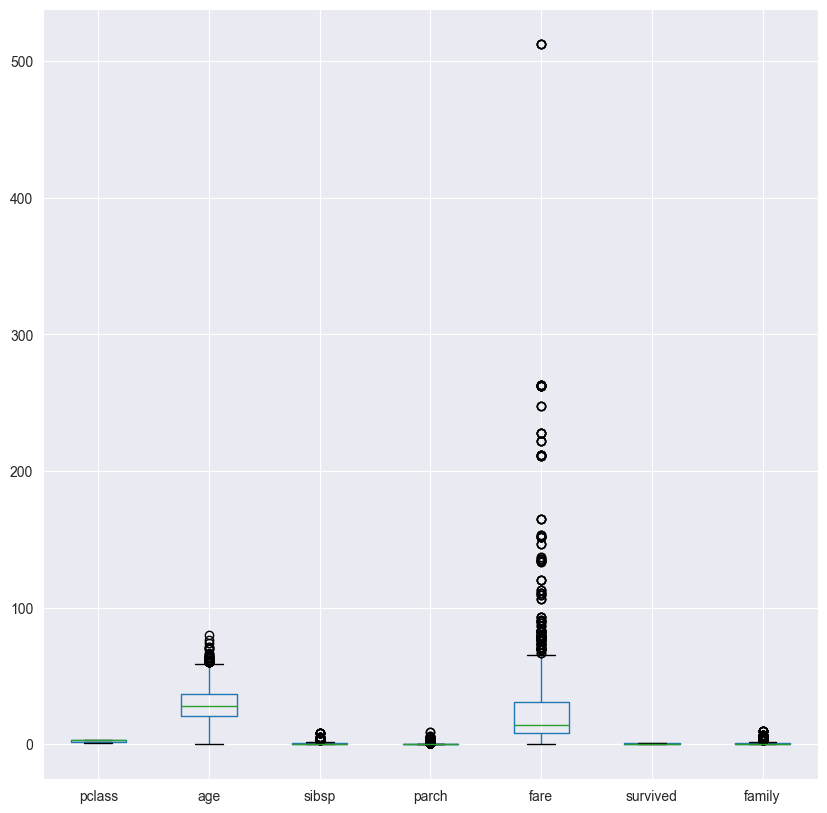

In [147]:
plt.figure(figsize=(10,10))
df.boxplot()

looking at the fare, there are many outliers and the data looks negatively skewed. let's take a closer look  

C:\Users\20115\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='fare', ylabel='Count'>

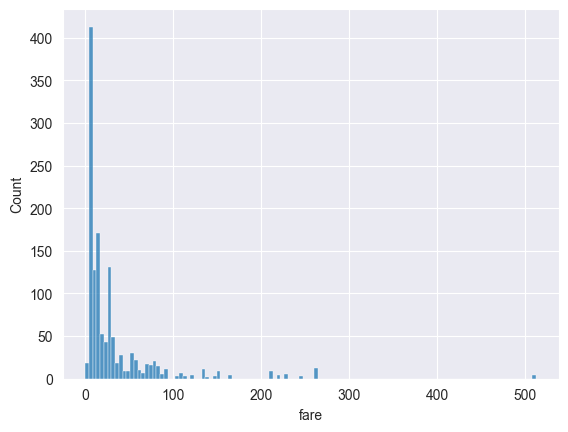

In [148]:
sns.histplot(x=df['fare'])

It is normal for the data to be negatively skewed, as there is a high chance that many people paid approximately the same price and that little number of people(probably important individuals belonging to pclass 3) therefore they are not actual outliers 

Now let's take a look at the age 

C:\Users\20115\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age', ylabel='Count'>

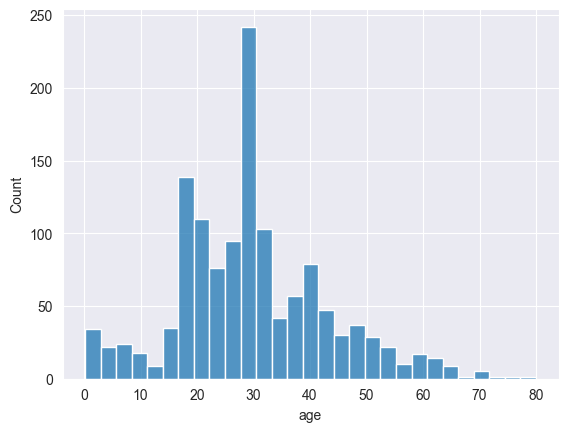

In [149]:
sns.histplot(x=df['age'])

It is not as negatively skewed as the fare, but it is still reasonable as the majority where from the age group is from 20 to 40 ,therefore no outliers will be removed 

Let's take a look at a correlation matrix

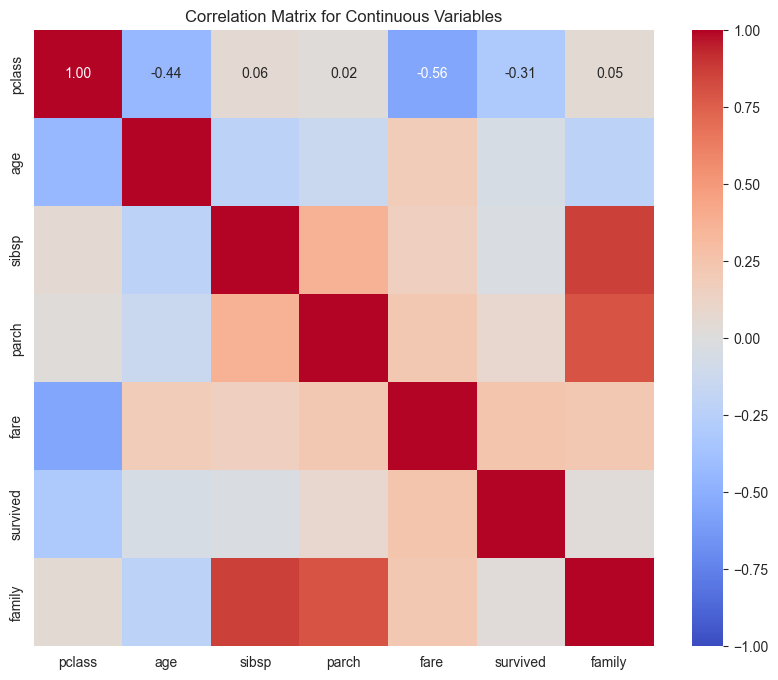

In [150]:
continuous=df.select_dtypes(['float64', 'int64']).columns.to_list()
corr_matrix = df[continuous].corr()
# Plot heatmap with adjusted settings
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 10})
plt.title('Correlation Matrix for Continuous Variables')
plt.show()


Looks like the pclass is a decision feature for whether a person survived or not and is positively correlated while age is positively correlated as the age increases the chance of surviving increases. let's take a look at the sex feature

In [151]:
df['sex'].value_counts()

sex
male      843
female    466
Name: count, dtype: int64

<Axes: xlabel='survived', ylabel='count'>

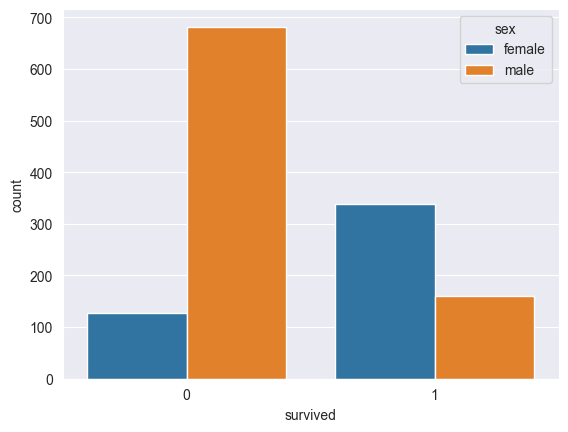

In [152]:
sns.countplot(x='survived',data=df,hue='sex')

looks like more females survived than males which kind of makes sense 

<Axes: xlabel='survived', ylabel='count'>

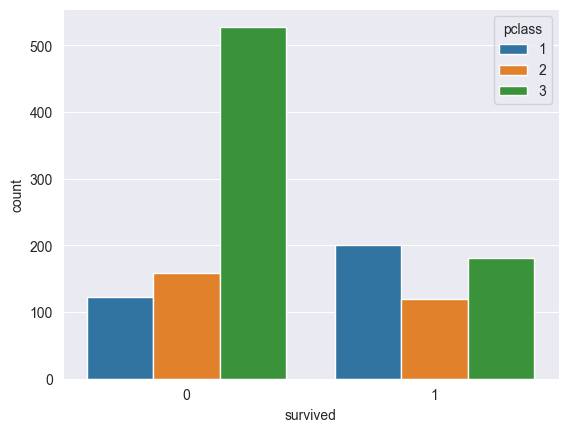

In [153]:
sns.countplot(x='survived',data=df,hue='pclass')

There is a large portion of who survived belong to pclass 3 , meaning that it is positevly correlated as pclass increases, the probability of surviving increases

<Axes: xlabel='pclass', ylabel='count'>

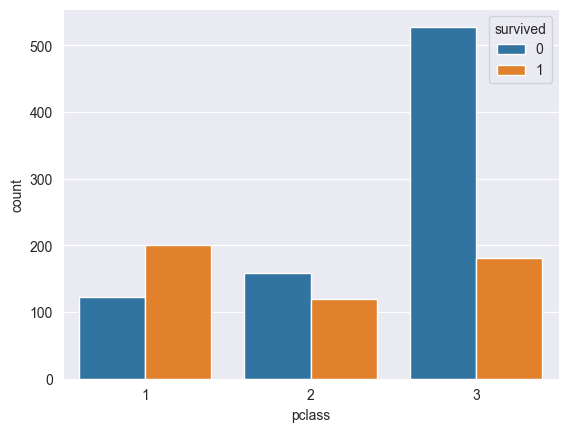

In [154]:
sns.countplot(x='pclass',data=df,hue='survived')

Now we will view the skewness of age 

C:\Users\20115\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\20115\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


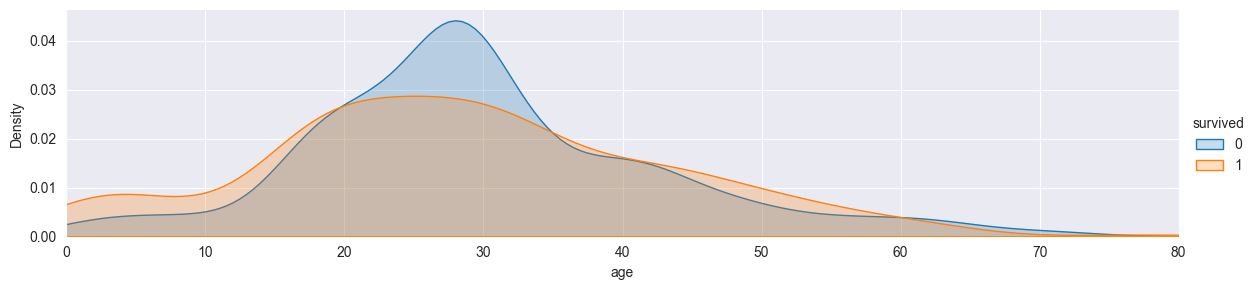

In [155]:
fig = sns.FacetGrid(df, hue = "survived", aspect = 4)
fig.map(sns.kdeplot, 'age', fill = True)
fig.set(xlim=(0, df['age'].max()))
fig.add_legend()

Sadly, younger kids and teenagers had a smaller chance of surviving 

C:\Users\20115\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\20115\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\20115\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


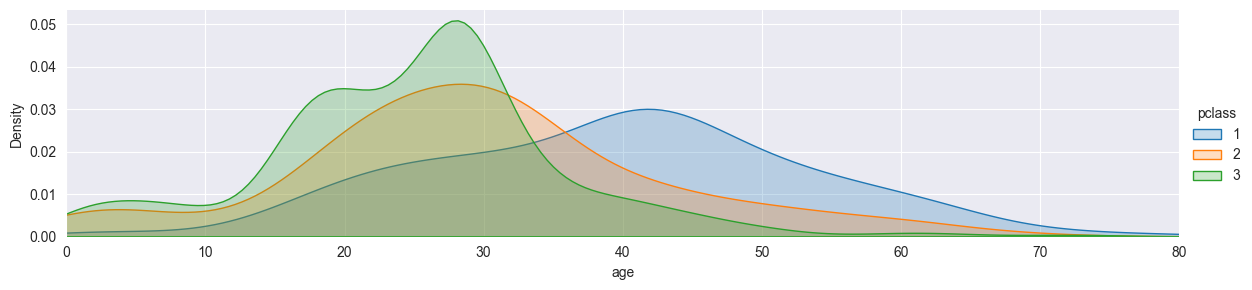

In [156]:
fig = sns.FacetGrid(df, hue = "pclass", aspect = 4)
fig.map(sns.kdeplot, 'age', fill = True)
fig.set(xlim=(0, df['age'].max()))
fig.add_legend()

Pclass 3 had the most children 

C:\Users\20115\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\20115\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\20115\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\20115\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

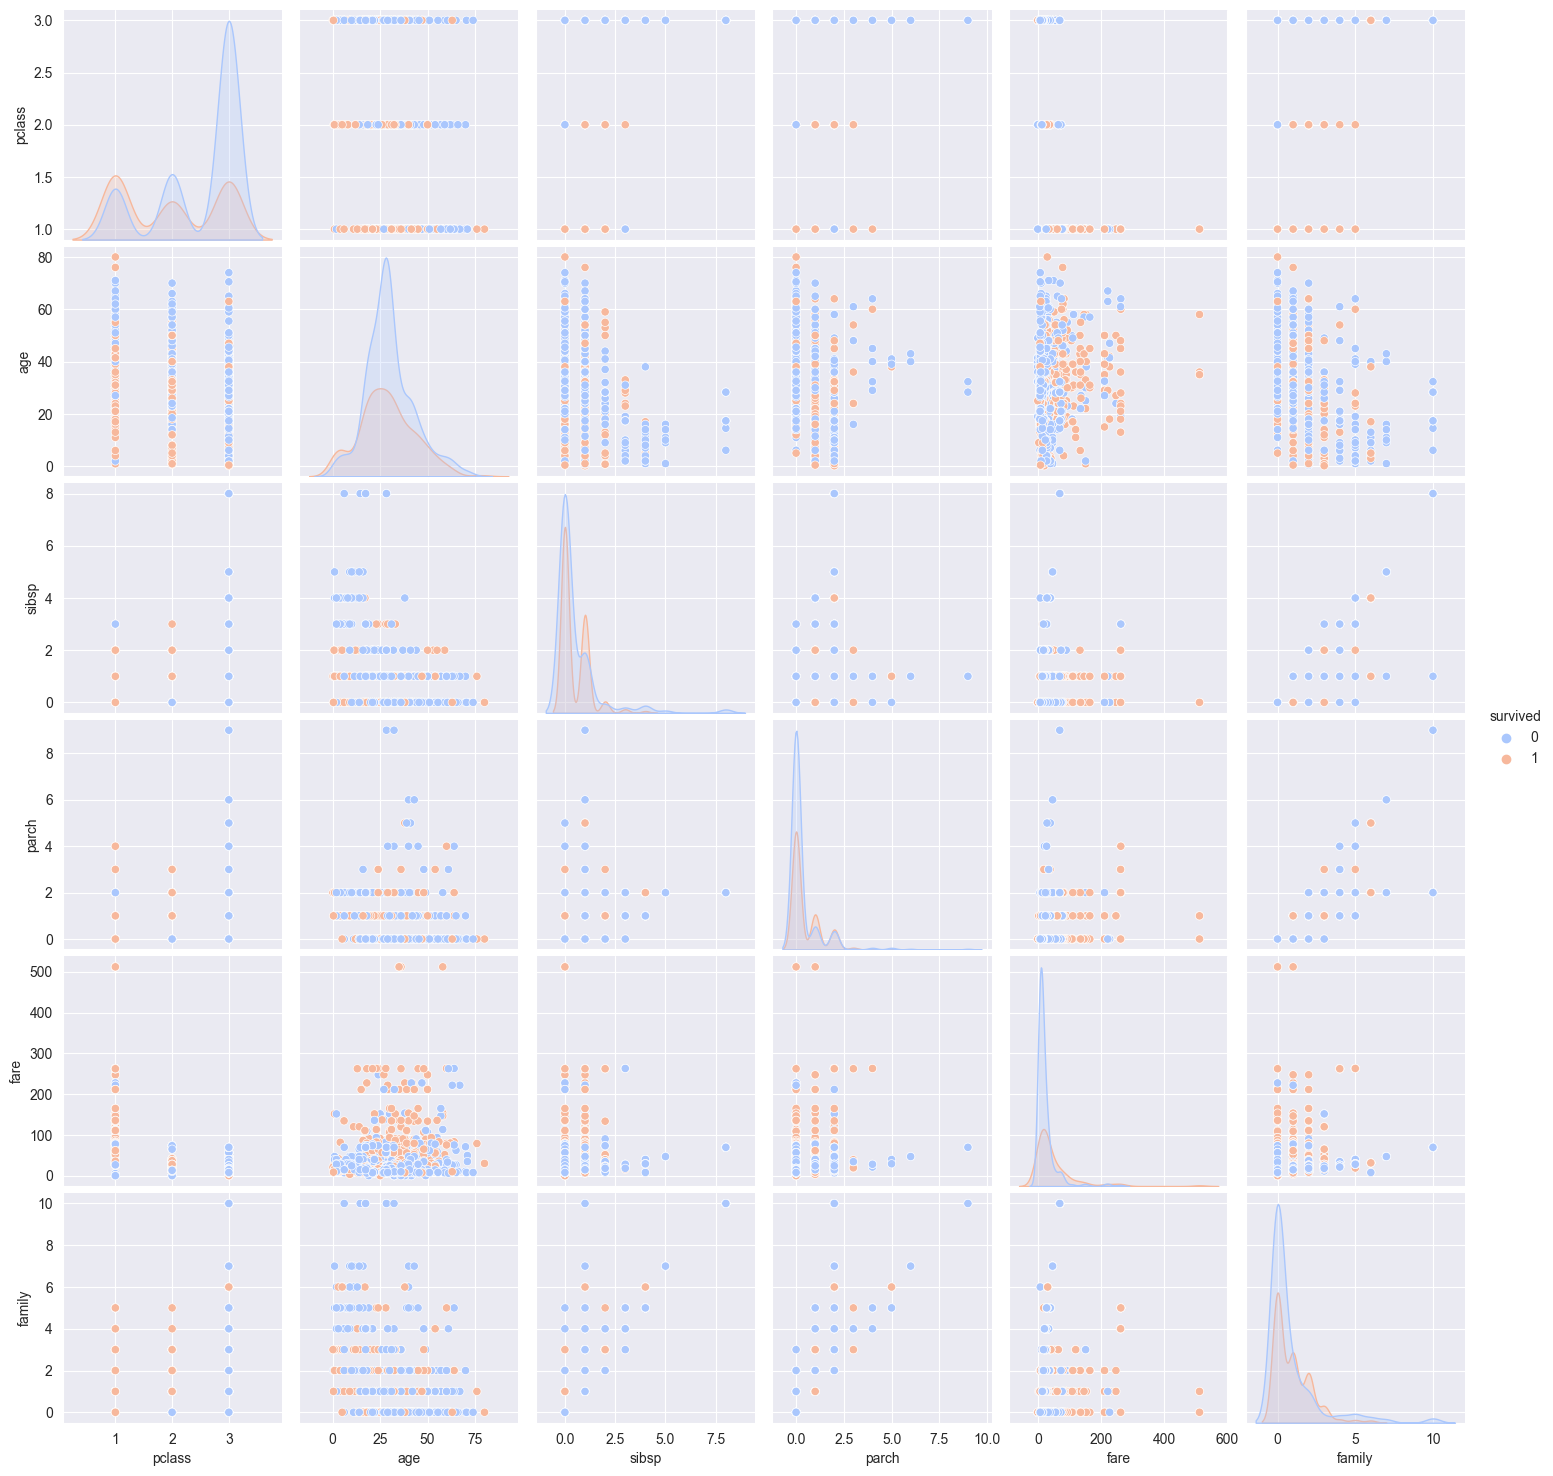

In [157]:
sns.pairplot(df,hue='survived',palette='coolwarm')

Now we need to encode categorical features to not interfere with the classification algorithm

In [158]:
categorical=df.select_dtypes(['object'])
encoded=pd.get_dummies(categorical)
encoded.replace([True, False], [1,0], inplace=True)
encoded_df=pd.concat([df, encoded], axis=1)
encoded_df.drop(['sex', 'embarked','title'],axis= 1,inplace =True)
df=encoded_df.iloc[:len(df)]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pclass         1309 non-null   int64  
 1   age            1309 non-null   float64
 2   sibsp          1309 non-null   int64  
 3   parch          1309 non-null   int64  
 4   fare           1309 non-null   float64
 5   survived       1309 non-null   int64  
 6   family         1309 non-null   int64  
 7   sex_female     1309 non-null   int64  
 8   sex_male       1309 non-null   int64  
 9   embarked_C     1309 non-null   int64  
 10  embarked_Q     1309 non-null   int64  
 11  embarked_S     1309 non-null   int64  
 12  title_Army     1309 non-null   int64  
 13  title_Dr       1309 non-null   int64  
 14  title_Master   1309 non-null   int64  
 15  title_Miss     1309 non-null   int64  
 16  title_Mr       1309 non-null   int64  
 17  title_Mrs      1309 non-null   int64  
 18  title_No

In [159]:
categorical=df_test.select_dtypes(['object'])
encoded=pd.get_dummies(categorical)
encoded.replace([True, False], [1,0], inplace=True)
encoded_df=pd.concat([df_test, encoded], axis=1)
encoded_df.drop(['sex', 'embarked','title'],axis= 1,inplace =True)
df_test=encoded_df.iloc[:len(df)]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pclass        19 non-null     int64  
 1   age           19 non-null     float64
 2   sibSp         19 non-null     int64  
 3   parch         19 non-null     int64  
 4   fare          19 non-null     float64
 5   family        19 non-null     int64  
 6   sex_female    19 non-null     int64  
 7   sex_male      19 non-null     int64  
 8   embarked_C    19 non-null     int64  
 9   embarked_Q    19 non-null     int64  
 10  embarked_S    19 non-null     int64  
 11  title_Army    19 non-null     int64  
 12  title_Master  19 non-null     int64  
 13  title_Miss    19 non-null     int64  
 14  title_Mr      19 non-null     int64  
 15  title_Mrs     19 non-null     int64  
dtypes: float64(2), int64(14)
memory usage: 2.5 KB


Now we will split the training,validation and test data  

In [160]:
X=df.drop('survived',axis=1)
y=df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## SVM Classification

SVM (Support vector machine) is a classification algorithm that looks for the largest margin separating the two classes apart 

In [161]:
scaler = StandardScaler()
X_train[['age', 'fare']] = scaler.fit_transform(X_train[['age','fare']])
X_test[['age', 'fare']] = scaler.transform(X_test[['age', 'fare']])

In [162]:
X_train.shape

(1047, 19)

In [163]:
X_test.shape

(262, 19)

In [164]:
y_train.shape

(1047,)

In [165]:
y_test.shape

(262,)

First of all there are many types of kernels, so now we will choose the most appropriate keranl

In [166]:
kernels=['linear','poly','rbf','sigmoid']
for kernel in kernels:
 svm=SVC(kernel=kernel)
 svm.fit(X_train, y_train)
 y_pred = svm.predict(X_test)
 print(f"kernel {kernel}")
 print(classification_report(y_test, y_pred,target_names=['survived','died']))

kernel linear
              precision    recall  f1-score   support

    survived       0.78      0.87      0.82       144
        died       0.81      0.69      0.75       118

    accuracy                           0.79       262
   macro avg       0.79      0.78      0.78       262
weighted avg       0.79      0.79      0.79       262

kernel poly
              precision    recall  f1-score   support

    survived       0.78      0.87      0.82       144
        died       0.81      0.69      0.75       118

    accuracy                           0.79       262
   macro avg       0.79      0.78      0.78       262
weighted avg       0.79      0.79      0.79       262

kernel rbf
              precision    recall  f1-score   support

    survived       0.78      0.87      0.82       144
        died       0.81      0.69      0.75       118

    accuracy                           0.79       262
   macro avg       0.79      0.78      0.78       262
weighted avg       0.79      0.79    

Sigmoid kernel has done the poorest therefore would be eliminated and since the other kernals gave the same outputs it's not going to matter which kernel is chosen from the three either linear , poly or rbf. for simplicity , I will choose linear

Now we will tune the hyperparathyroidism gamma and C 
gamma is the influence of training examples on the decision boundary and C is the regularization parameter

First we will initalize random varaiables for each hyperparameter

In [167]:
svm= SVC()
parameters= {'gamma':[1, 0.1,0.01 ,0.001 ,0.0001], 'C':[0.1,1,10,100, 1000]}

We will perform a grid search to see which value is the best for each parameter 

In [168]:
grid= GridSearchCV(estimator= svm,param_grid = parameters,cv =5,scoring ='accuracy')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001]},
             scoring='accuracy')

In [169]:
best_gamma= grid.best_params_['gamma']
best_C =grid.best_params_['C']
print('Grid Search Results')
print('Best value of gamma:', best_gamma)
print('Best value of C:', best_C)
print(f'Accuracy at gamma = {best_gamma}, C = {best_C}')
print(f'{grid.best_score_*100:.2f}' + '%')

Grid Search Results
Best value of gamma: 0.01
Best value of C: 10
Accuracy at gamma = 0.01, C = 10
81.94%


Now , lets start the actual training

In [170]:
svm = SVC(kernel = 'linear', gamma = best_gamma, C = best_C)
svm.fit(X_train, y_train)

SVC(C=10, gamma=0.01, kernel='linear')

In [171]:
y_pred = svm.predict(X_test)

Now we will add the predictions to the test df 

The 3 columns introduced is just to make the test features equal to the training features

In [174]:
df_test['title_Dr'] = 0
df_test['title_Noble'] = 0
df_test['title_Royalty'] = 0
df_test = df_test[X_train.columns]
new_preds = svm.predict(df_test)

## Evaluating Performance

In [176]:
confusion = confusion_matrix(y_test, y_pred.astype('int64'))
confusion

array([[125,  19],
       [ 36,  82]], dtype=int64)

Let's visualize it 

<Axes: >

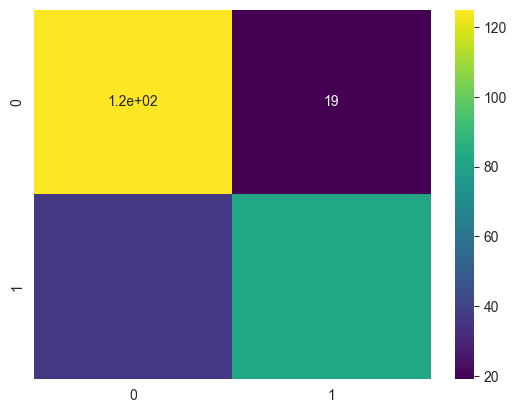

In [178]:
sns.heatmap(confusion,annot=True,cmap='viridis')

Since there are large TP and FP values then the svm is a good classification algorithm,let's just print a classifcation report to check precision , accuracy , recall and f1-score 

In [179]:
print(classification_report(y_test, y_pred,target_names=['survived','died']))

              precision    recall  f1-score   support

    survived       0.78      0.87      0.82       144
        died       0.81      0.69      0.75       118

    accuracy                           0.79       262
   macro avg       0.79      0.78      0.78       262
weighted avg       0.79      0.79      0.79       262



The accuracy of the SVM is 79% which is a little shady but not bad it has a good overall f1-score and the recall for the survived is higher than the recall for the died samples.